In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t, f, norm
from scipy.optimize import minimize
import statsmodels.api as sm

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures

In [160]:
class logistic_regression:
    def __init__(self, solver = 'lbfgs', penalty = 'l2', C = 1., tol = 1e-8, max_iter=100):
        self.solver = solver
        self.penalty = penalty
        self.C = C
        self.tol = tol
        self.max_iter = max_iter

    def _sigmoid(self, beta, data):
        return 1/(1+np.exp(-data.dot(beta)))
    
    def _llf_none(self, beta, data, label, ):
        target = np.array([-1 if i ==0 else 1 for i in label.values])
        value = sum( np.log( 1/( 1+np.exp(-(target*(data.dot(beta)))) ) ) )
        return -value
    
    def _llf_l2(self, beta, data, label, ):
        target = np.array([-1 if i ==0 else 1 for i in label.values])
        value = sum( np.log( 1/( 1+np.exp(-(target*(data.dot(beta)))) ) ) )
        return -(self.C * value) + beta.dot(beta)/2

    def _irls(self, data, label, w_init, penalty, C, cnvg_tol, max_iter):
        x = data.copy()
        w = w_init.copy()
        mu = 1/(1+np.exp(-x.dot(w)))

        s = np.zeros((data.shape[0], data.shape[0]))
        np.fill_diagonal(s, [i*(1-i) for i in mu])
        cost = 0

        for n_iter in range(max_iter):
            w_0 = w
            w = np.linalg.inv( (x.T).dot(s.dot(x)) ).dot(x.T).dot( s.dot(x.dot(w)) + label.values - mu )
            if penalty == 'none':
                c = self._llf_none(w, x, label)
            elif penalty == 'l2':
                c = self._llf_l2(w, x, label)
            else:
                raise ValueError("This penalty is not supported yet.") from None

            if n_iter==0:
                cost = c
                mu = 1/(1+np.exp(-x.dot(w)))
                np.fill_diagonal(s, [i*(1-i) for i in mu])
            else:
                if (c > cost)|(c!=c)|((cost - c) < cnvg_tol):
                    w = w_0
                    break
                else:
                    cost = c
                    mu = 1/(1+np.exp(-x.dot(w)))
                    np.fill_diagonal(s, [i*(1-i) for i in mu])
            
        return w, n_iter
    
    def fit(self, X, y):
        X_ = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        
        b0_init = np.log(y.mean()/(1- y.mean()))
        self.coef_ = np.array([b0_init]+[.0]*(X.shape[1]))
        
        if self.solver == 'lbfgs':
            if self.penalty == 'l2':
                coef =  minimize(self._llf_l2, x0 = self.coef_, args = (X_, y), method = 'L-BFGS-B', )['x'] #options={'gtol': 1e-3, 'disp': True}
                self.coef_ = coef.copy()
                self.log_likelihood = -self._llf_l2(coef, X_, y)
            elif self.penalty == 'none':
                coef =  minimize(self._llf_none, x0 = self.coef_, args = (X_, y), method = 'L-BFGS-B', )['x']
                self.coef_ = coef.copy()
                self.log_likelihood = -self._llf_none(coef, X_, y)
            else:
                raise ValueError("Solver lbfgs supports only 'l2' or 'none' penalties") from None
        elif self.solver == 'irls':
            coef, self.n_iter = self._irls(X_, y, self.coef_, self.penalty, self.C, self.tol, self.max_iter)
            self.coef_ = coef.copy()
            if self.penalty=='l2':
                self.log_likelihood = -self._llf_l2(coef, X_, y)
            else:
                self.log_likelihood = -self._llf_none(coef, X_, y)
        else:
            raise ValueError("This Solver is not supported.") from None
        
        n = X.shape[0]
        p = X.shape[1]
        self.n_samples = n
        self.n_features = p
        
        mu = self._sigmoid(self.coef_, X_)
        if self.solver=='irls':
            self.deviance = -2*( ((X_.dot(self.coef_)).T).dot(y) + np.log(1 - mu).sum() )
            self.residual_deviance = np.sqrt( -2*( (X_.dot(self.coef_))*(y) + np.log(1 - mu) ) )* np.sign(y - mu)
        self.residual_pearson = (y - mu)/np.sqrt(mu*(1-mu))
        self.pearson_chi2 = np.square(self.residual_pearson).sum()
        
        S = np.zeros((X_.shape[0], X_.shape[0]))
        np.fill_diagonal(S, [i*(1-i) for i in mu])
        covar = np.linalg.inv((X_.T).dot(S.dot(X_)))
        
        self.std_error = np.sqrt(np.diag( covar ))
        self.z_values = self.coef_ / self.std_error
        self.z_pvalues = [2*(1 - norm.cdf(abs(i),)) for i in self.z_values]
    
    def predict(self, X):
        X_ = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        result = np.array([1 if i >= .5 else 0 for i in self._sigmoid(self.coef_, X_)])
        return result
    
    def predict_proba(self, X):
        X_ = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        result = np.vstack((1. - self._sigmoid(self.coef_, X_), self._sigmoid(self.coef_, X_)))
        return result.T
    
    def score(self, X, y):
        pred = self.predict(X,)
        return np.array(pred==y, dtype=int).sum() / y.size
    
    def summary(self, feature_names = None, round_decimals=3, alpha=0.05):
        '''res_min = self.residual.min()
        res_max = self.residual.max()
        res_1q = np.quantile(self.residual, .25)
        res_med = np.median(self.residual)
        res_3q = np.quantile(self.residual, .75)
        res = pd.DataFrame(np.array([res_min, res_1q, res_med, res_3q, res_max]).reshape(1,-1), columns = ['Residuals: Min', '1Q', 'Median', '3Q', 'Max'])'''
        
        ci_lower = np.round(self.coef_ - self.std_error * norm.ppf(1-alpha/2, ), round_decimals)
        ci_upper = np.round(self.coef_ + self.std_error * norm.ppf(1-alpha/2, ), round_decimals)
        if feature_names is None:
            feat_idx = ['x0(INTCP)'] + ['x{}'.format(i) for i in range(1, self.n_features+1)]
            coef = pd.DataFrame(np.array([self.coef_, self.std_error, self.z_values, np.round(self.z_pvalues, round_decimals), ci_lower, ci_upper]).T, index = feat_idx, columns= 
                               ['coef.', 'std. error', 'z_value', 'Pr(>|z|)', '{}% LWR'.format(int(100*(1-alpha))), '{}% UPR'.format(int(100*(1-alpha)))])
        else:
            feat_idx = np.insert(feature_names, 0, '(INTCP)')
            coef = pd.DataFrame(np.array([self.coef_, self.std_error, self.z_values, np.round(self.z_pvalues, round_decimals), ci_lower, ci_upper]).T, index = feat_idx, columns= 
                               ['coef.', 'std. error', 'z_value', 'Pr(>|z|)', '{}% LWR'.format(int(100*(1-alpha))), '{}% UPR'.format(int(100*(1-alpha)))])
        
        if self.solver == 'irls':
            result = 'No. Observations: {}\nDF Residuals: {}\nLog-likelihood: {}\nDeviance: {}\nPearson chi2: {}'.format(self.n_samples, self.n_features, self.log_likelihood, self.deviance, self.pearson_chi2)
            sol = 'Solver: {}\nNo. Iterations: {}'.format(self.solver.upper(), self.n_iter)
            print(sol, result, coef, sep='\n'+'='*70+'\n')
        else:
            result = 'No. Observations: {}\nDF Residuals: {}\nLog-likelihood: {}\nPearson chi2: {}'.format(self.n_samples, self.n_features, self.log_likelihood, self.pearson_chi2)
            print(result, coef, sep='\n'+'='*70+'\n')

# Load data

In [93]:
data = load_breast_cancer()
X, y, feature_names,  = data['data'], 1 - data['target'], data['feature_names']


In [94]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X, columns = feature_names), pd.Series(y, name='label'), test_size = .2, random_state=42)

In [95]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train

## irls

In [97]:
Xs = sm.add_constant(X_train[:, -6:])
logit = sm.GLM(y_train, Xs, family=sm.families.Binomial(), )
result = logit.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  label   No. Observations:                  455
Model:                            GLM   Df Residuals:                      448
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89.286
Date:                Mon, 30 Aug 2021   Deviance:                       178.57
Time:                        21:12:38   Pearson chi2:                 1.48e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2369      0.216     -5.728      0.0

In [103]:
lr = logistic_regression(solver = 'irls', penalty='none', C=1.)
lr.fit(X_train[:, -6:], y_train)

lr.summary()

Solver: IRLS
No. Iterations: 7
No. Observations: 455
DF Residuals: 6
Log-likelihood: -89.28573873312577
Deviance: 178.5714774662954
Pearson chi2: 1484.4789667633481
              coef.  std. error   z_value  Pr(>|z|)  95% LWR  95% UPR
x0(INTCP) -1.236908    0.215952 -5.727696     0.000   -1.660   -0.814
x1         0.269614    0.288392  0.934889     0.350   -0.296    0.835
x2         0.235429    0.561026  0.419640     0.675   -0.864    1.335
x3         0.216709    0.495205  0.437615     0.662   -0.754    1.187
x4         4.489082    0.625409  7.177829     0.000    3.263    5.715
x5         0.705100    0.280765  2.511349     0.012    0.155    1.255
x6        -1.553841    0.442719 -3.509767     0.000   -2.422   -0.686


## l-bfgs

In [161]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]
print('sklearn: accuracy',model.score(X_test, y_test))

sklearn: accuracy 0.9736842105263158


In [162]:
lr_lb = logistic_regression(solver = 'lbfgs', penalty='l2', C=1.)
lr_lb.fit(X_train, y_train)
pred_ = lr_lb.predict_proba(X_test)[:, 1]
print('sklearn: accuracy', lr_lb.score(X_test, y_test))

sklearn: accuracy 0.9736842105263158


In [163]:
print('coef. sklearn == my implementation?:', np.allclose(np.append(model.intercept_, model.coef_.flatten()), lr_lb.coef_) )

coef. sklearn == my implementation?: False


In [170]:
abs(pred - pred_).mean()

0.0009100549773208128

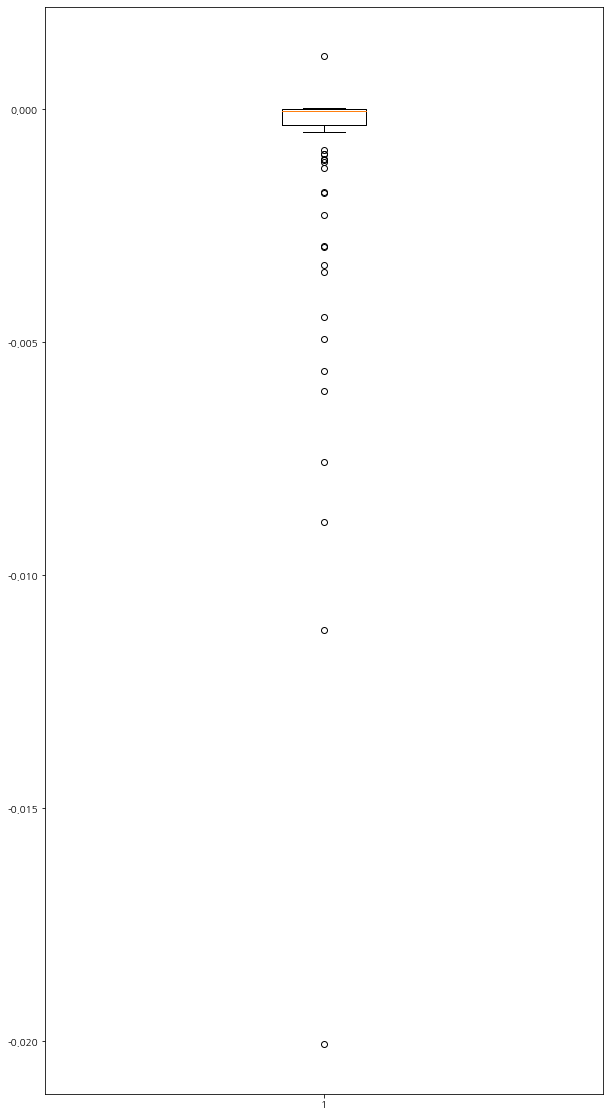

In [173]:
plt.figure(figsize=(10,20))
plt.boxplot((pred - pred_), )
plt.show()